In [30]:
import torch
from PIL import Image
import sys
from pathlib import Path

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from metric_depth.zoedepth.models.builder import build_model
from metric_depth.zoedepth.utils.config import get_config
from metric_depth.zoedepth.utils.misc import save_raw_16bit, colorize

# Load the model
config = get_config("zoedepth", "eval", "kitti")
config.pretrained_resource = "local::/checkpoints/depth_anything_metric_depth_outdoor.pt"
zoe = build_model(config).to('cuda' if torch.cuda.is_available() else 'cpu')

Params passed to Resize transform:
	width:  518
	height:  392
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  14
	resize_method:  minimal
Using pretrained resource local::/checkpoints/depth_anything_metric_depth_outdoor.pt
Loaded successfully


In [7]:
image = Image.open("/home/emilia/MasterOfFish/data/YC1/frames/left/frame_0.jpg")
depth = zoe.infer_pil(image)

In [31]:
import sys
from pathlib import Path

root_dir = Path().resolve().parent.parent  
sys.path.append(str(root_dir))


from Baseline.lib.calibration import StereoManager, CameraParameters, StereoParameters
calib_path = "/home/emilia/MasterOfFish/StereoDepth/stereoMap.pickle"

sm = StereoManager()
sm.load_calibration(calib_path)

left_fx = sm.cam_parameters[0].camera_matrix[0, 0]
left_fy = sm.cam_parameters[0].camera_matrix[1,1]

right_fx = sm.cam_parameters[1].camera_matrix[0, 0]
right_fy = sm.cam_parameters[1].camera_matrix[1,1]




In [22]:
import argparse
import os
import glob
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
# import open3d as o3d
from tqdm import tqdm
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
import pandas as pd

# Global settings
FL = 715.0873
FY = left_fy
FX = left_fx
NYU_DATA = False
FINAL_HEIGHT = 256
FINAL_WIDTH = 256
INPUT_DIR = './my_test/input'
OUTPUT_DIR = './my_test/output'
DATASET = 'kitti' 

def process_images(model):
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    image_paths = glob.glob(os.path.join(INPUT_DIR, '*.png')) + glob.glob(os.path.join(INPUT_DIR, '*.jpg'))
    for image_path in tqdm(image_paths, desc="Processing Images"):
        try:
            color_image = Image.open(image_path).convert('RGB')
            w, h = color_image.size
            image_tensor = transforms.ToTensor()(color_image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

            pred = model.infer(image_tensor)
            if isinstance(pred, dict):
                pred = pred.get('metric_depth', pred.get('out'))
            elif isinstance(pred, (list, tuple)):
                pred = pred[-1]
            pred = pred.squeeze().detach().cpu().numpy()

            # Resize color image and depth to final size
            # resized_color_image = color_image.resize((FINAL_WIDTH, FINAL_HEIGHT), Image.LANCZOS)
            # resized_pred = Image.fromarray(pred).resize((FINAL_WIDTH, FINAL_HEIGHT), Image.NEAREST)

            focal_length_x, focal_length_y = (FX, FY) #if not NYU_DATA else (FL, FL)
            x, y = np.meshgrid(np.arange(w), np.arange(h))
            x = (x - w / 2) / focal_length_x
            y = (y - h / 2) / focal_length_y
            z = np.array(pred)
            points = np.stack((np.multiply(x, z), np.multiply(y, z), z), axis=-1).reshape(-1, 3)
            colors = np.array(color_image).reshape(-1, 3) / 255.0

            df = pd.DataFrame(points, columns=['x', 'y', 'z'])
            df[['red', 'green', 'blue']] = pd.DataFrame(colors * 255, index=df.index)  # Assuming colors were normalized to [0, 1]
            df_output_path = os.path.join(OUTPUT_DIR, os.path.splitext(os.path.basename(image_path))[0] + ".csv")
            df.to_csv(df_output_path, index=False)

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

def main(model_name, pretrained_resource):
    config = get_config(model_name, "eval", DATASET)
    config.pretrained_resource = pretrained_resource
    model = build_model(config).to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    process_images(model)




In [34]:
def load_depth_model():
    model_name = "zoedepth"
    pretrained_resource = "local::/checkpoints/depth_anything_metric_depth_outdoor.pt"
    config = get_config(model_name, "eval", DATASET)
    config.pretrained_resource = pretrained_resource
    model = build_model(config).to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    return model

zoe = load_depth_model()

Params passed to Resize transform:
	width:  518
	height:  392
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  14
	resize_method:  minimal
Using pretrained resource local::/checkpoints/depth_anything_metric_depth_outdoor.pt
Loaded successfully



0: 416x640 17 fishs, 48.6ms
Speed: 9.6ms preprocess, 48.6ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


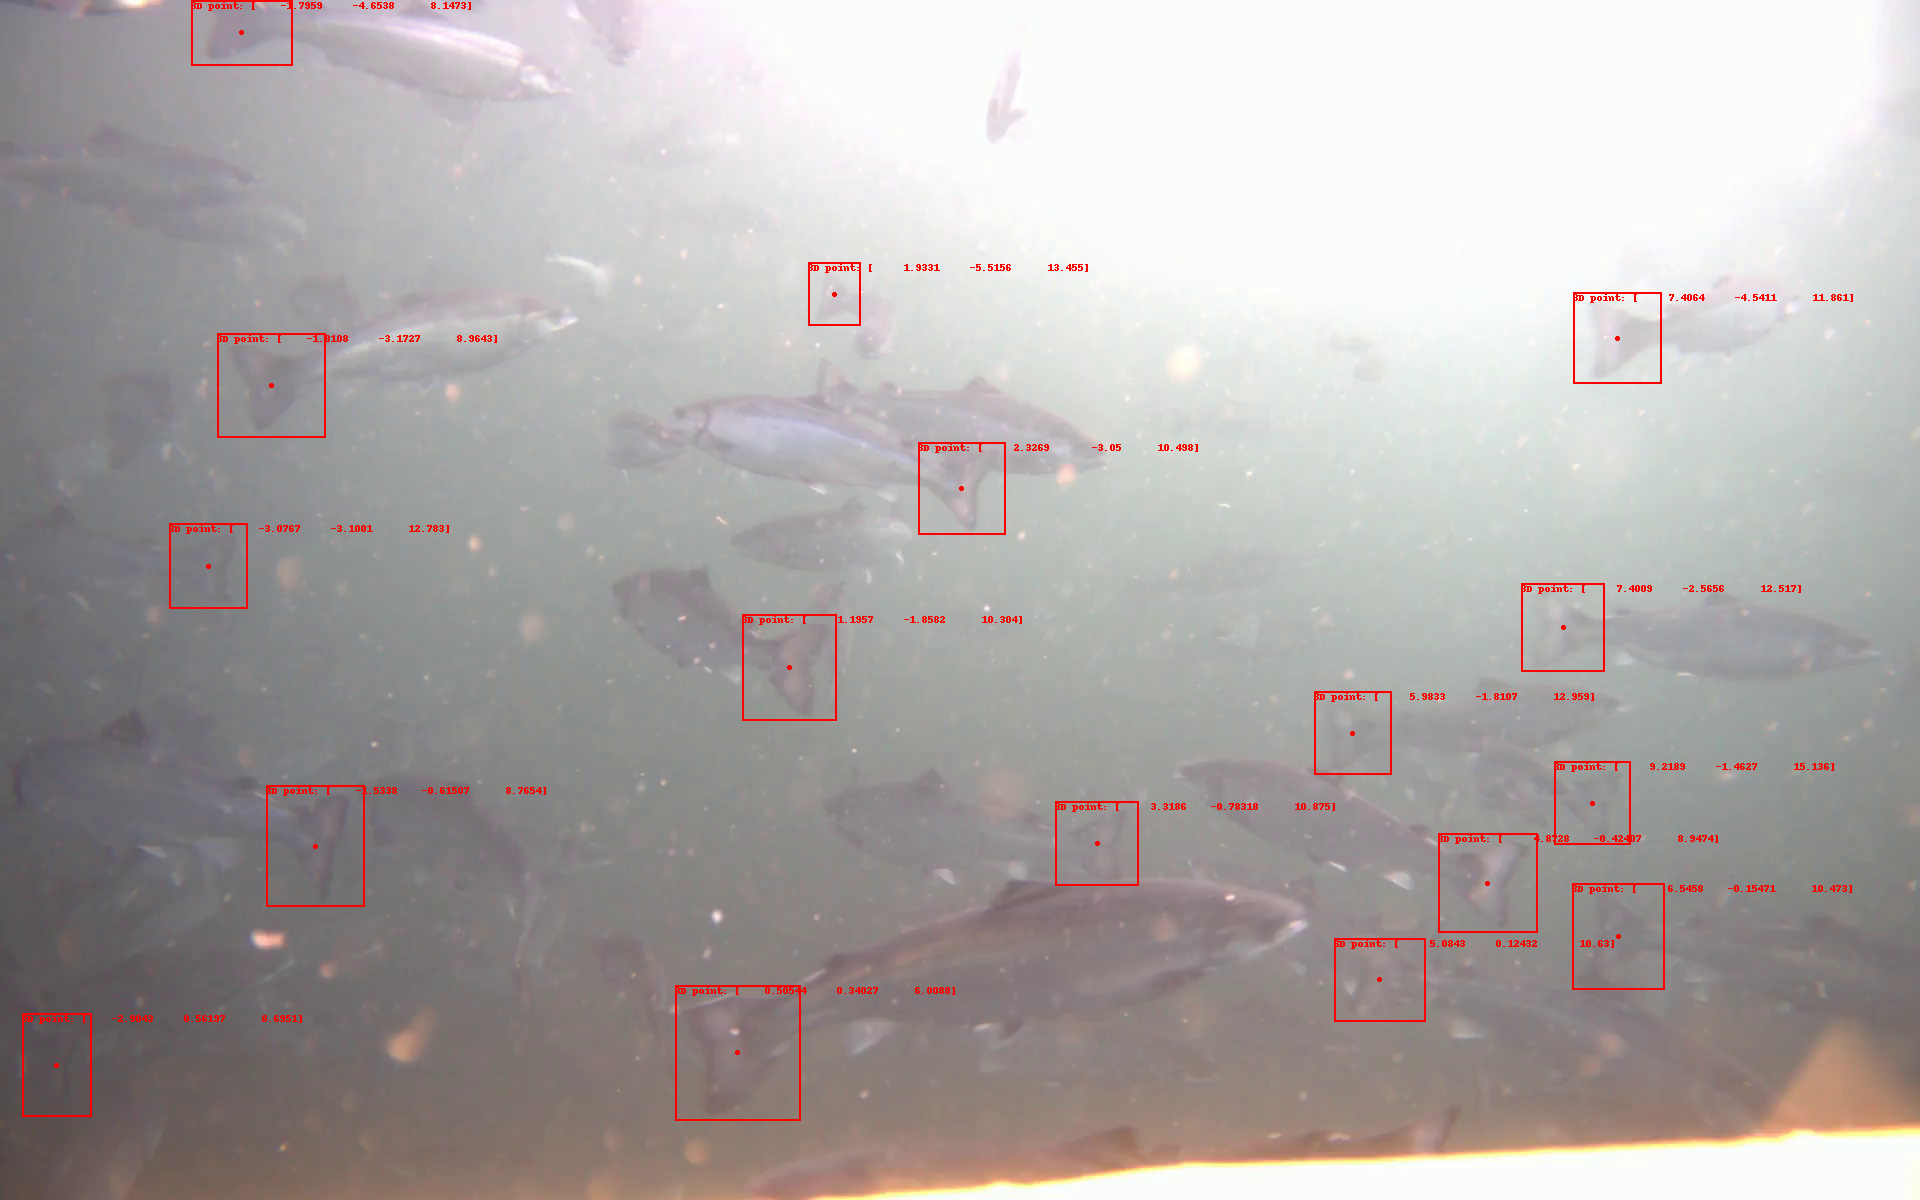

In [50]:
from ultralytics import YOLO
import supervision as sv
import torch
import cv2
import numpy as np
from PIL import Image, ImageDraw


def from_pixel_to_3d(u_x, u_y, fx, fy, depth_map):
    h, w = depth_map.shape
    z_3d = depth_map[u_y, u_x]
    x_3d = (u_x - h / 2) / fx * z_3d
    y_3d = (u_y - w / 2) / fy * z_3d
    point_3d = np.array([x_3d, y_3d, z_3d])
    return point_3d

def detect_objects(l_img, model):
    """
    Detect objects in the left image
    """
    # Perform detection on left image
    left_pred = model(l_img)

    return left_pred[0].boxes.cpu().numpy()

def compute_depth_map(image, model):
    try:
        image_tensor = transforms.ToTensor()(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
        pred = model.infer(image_tensor)
        pred = pred.squeeze().detach().cpu().numpy()

        depth_map = np.array(pred)
        return depth_map

    except Exception as e:
        print(f"Error processing image: {e}")

def draw_boxes(image, boxes, l_depth):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        x1, y1, x2, y2 = box
        centre_point = ((x1 + x2) / 2, (y1 + y2) / 2)
        u_x = int((x1 + x2) / 2)
        u_y = int((y1 + y2) / 2)
        point_3d = from_pixel_to_3d(u_x, u_y, left_fx, left_fy, l_depth)
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.ellipse([centre_point[0] - 2, centre_point[1] - 2, centre_point[0] + 2, centre_point[1] + 2], fill="red")
        draw.text((x1, y1), f"3D point: {point_3d}", fill="red")
    return image

# zoe = load_depth_model()
model = YOLO("/home/emilia/MasterOfFish/Baseline/lib/yolo_weights/initial.pt")
l_img = Image.open("/home/emilia/MasterOfFish/data/YC1/frames/left/frame_0.jpg")

l_det = detect_objects(l_img, model)
l_depth = compute_depth_map(l_img, zoe)

annotated_image = draw_boxes(l_img.copy(), l_det.xyxy, l_depth)
annotated_image.show()

ValueError: Could not save to JPEG for display

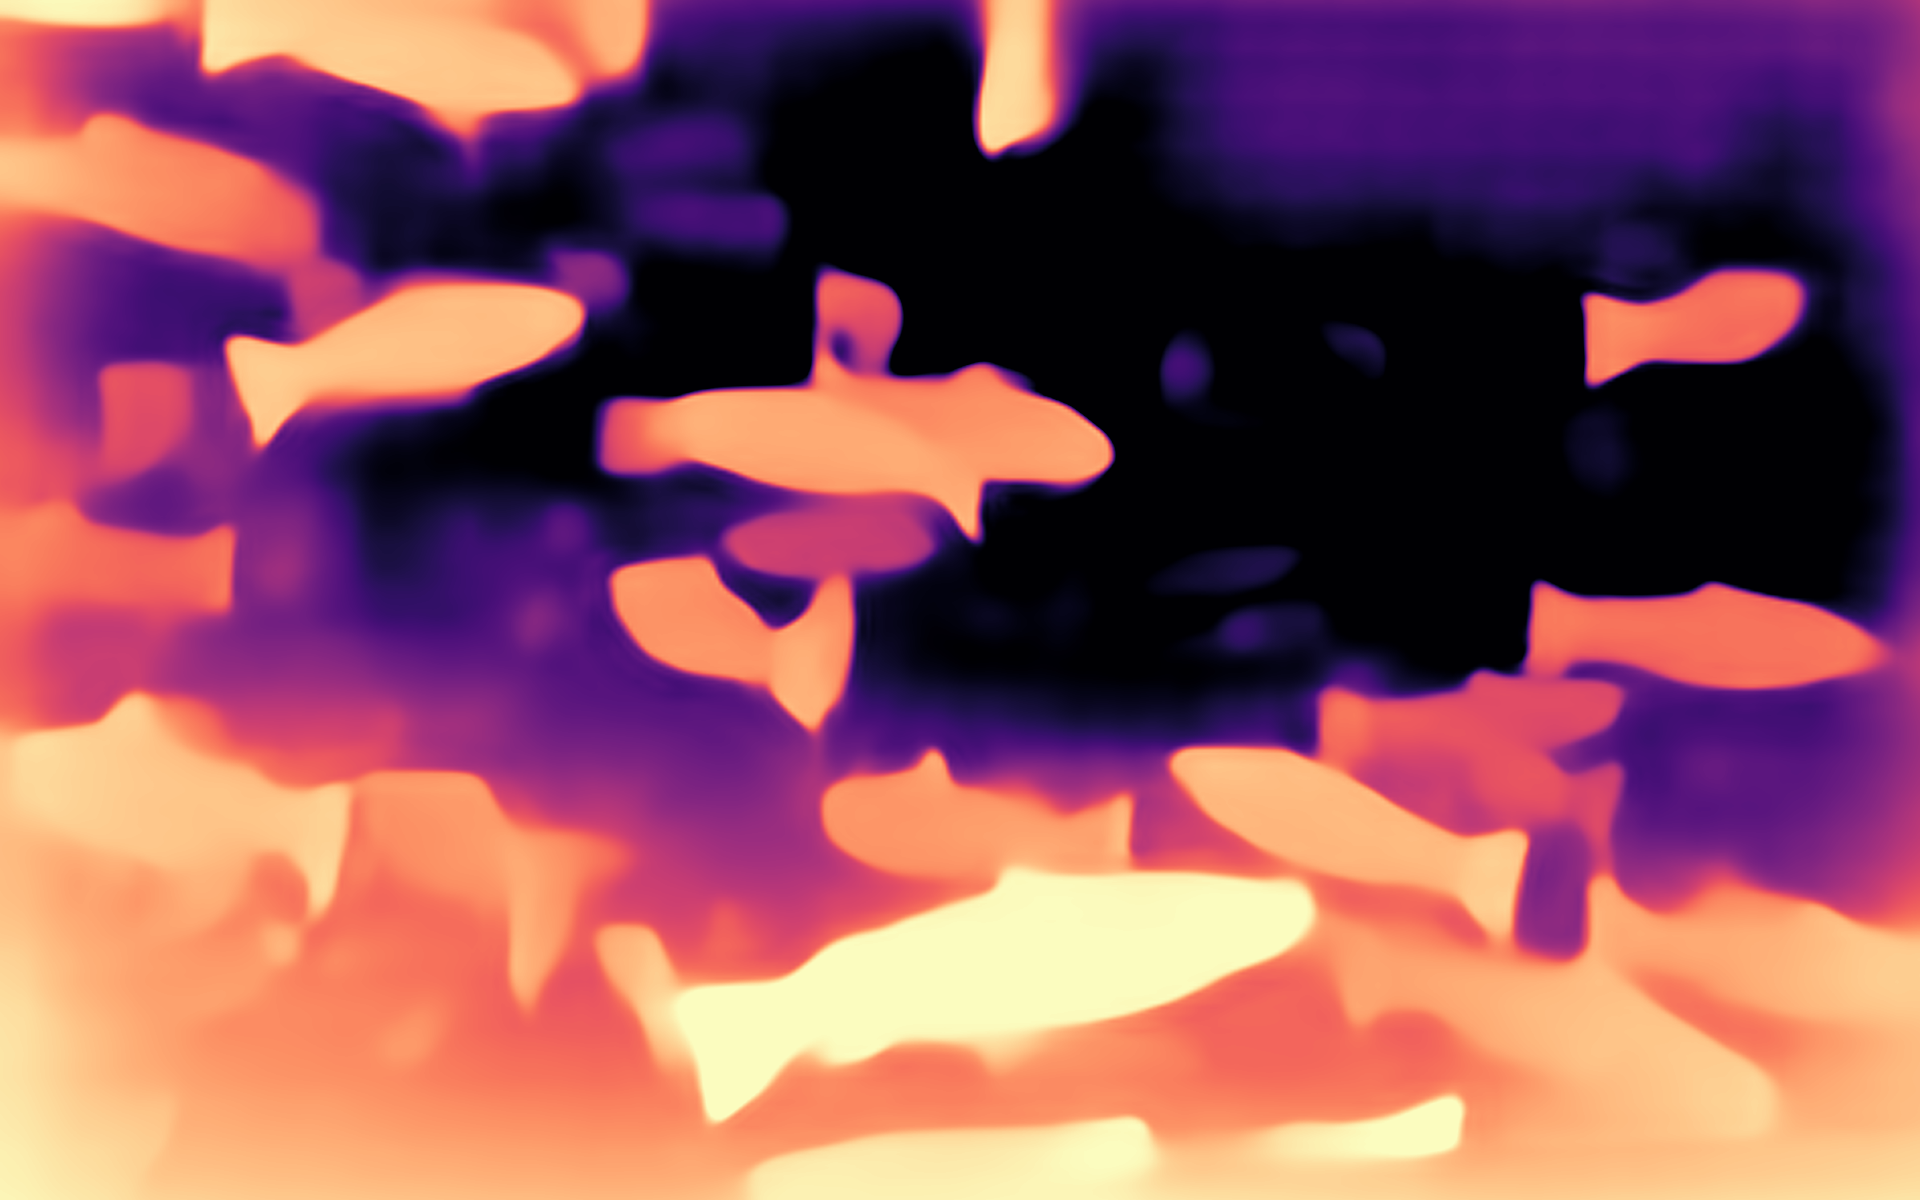

In [48]:
# show depth map
colorized_depth = colorize(l_depth)

Image.fromarray(colorized_depth).show()

In [27]:
image = Image.open("/home/emilia/MasterOfFish/data/YC1/frames/left/frame_0.jpg")

image_tensor = transforms.ToTensor()(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
model.infer(image_tensor)
pred = model.infer(image_tensor)
pred = pred.squeeze().detach().cpu().numpy()
z = np.array(pred)
h, w = z.shape
x, y = np.meshgrid(np.arange(w), np.arange(h))


x = (x - w / 2) / FX
y = (y - h / 2) / FY
points = np.stack((np.multiply(x, z), np.multiply(y, z), z), axis=-1).reshape(-1, 3)
print(points)

[[-4.34234191 -2.72075737  7.36700058]
 [-4.33758223 -2.72060909  7.36659908]
 [-4.33236923 -2.72017588  7.36542606]
 ...
 [ 4.63776124  2.91010763  7.89285946]
 [ 4.64172725  2.90955594  7.89136314]
 [ 4.64573185  2.90902956  7.88993549]]


In [28]:
import pandas as pd

df = pd.read_csv('/home/emilia/MasterOfFish/DepthAny/metric_depth/my_test/output/frame_0.csv')

print(df.head())

          x         y         z    red  green   blue
0 -4.342342 -2.720757  7.367001  108.0  106.0  119.0
1 -4.337582 -2.720609  7.366599  109.0  107.0  120.0
2 -4.332369 -2.720176  7.365426  109.0  107.0  120.0
3 -4.326676 -2.719440  7.363433  109.0  107.0  120.0
4 -4.321217 -2.718850  7.361835  109.0  107.0  120.0


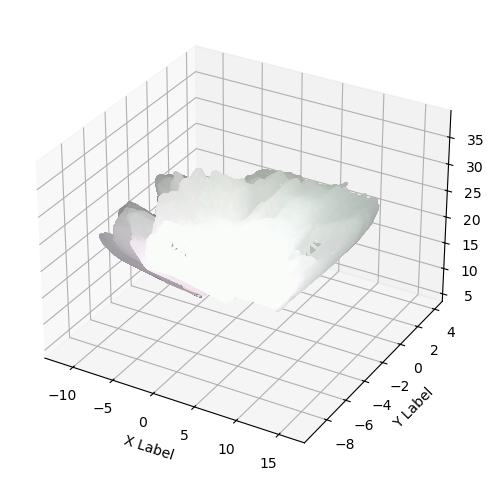

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Creating a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting
scatter = ax.scatter(df['x'], df['y'], df['z'], c=df[['red', 'green', 'blue']] / 255, s=1)  # Assuming color values are in [0, 255]

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# https://github.com/isl-org/ZoeDepth/blob/main/ui/gradio_im_to_3d.py

In [12]:
import numpy as np
import trimesh
from zoedepth.utils.geometry import depth_to_points, create_triangles
from PIL import Image


def depth_edges_mask(depth):
    """Returns a mask of edges in the depth map.
    Args:
    depth: 2D numpy array of shape (H, W) with dtype float32.
    Returns:
    mask: 2D numpy array of shape (H, W) with dtype bool.
    """
    # Compute the x and y gradients of the depth map.
    depth_dx, depth_dy = np.gradient(depth)
    # Compute the gradient magnitude.
    depth_grad = np.sqrt(depth_dx ** 2 + depth_dy ** 2)
    # Compute the edge mask.
    mask = depth_grad > 0.05
    return mask


def predict_depth(model, image):
    depth = model.infer_pil(image)
    return depth

def get_mesh(model, image, keep_edges=False):
    depth = predict_depth(model, image)
    pts3d = depth_to_points(depth[None])
    pts3d = pts3d.reshape(-1, 3)

    # Create a trimesh mesh from the points
    # Each pixel is connected to its 4 neighbors
    # colors are the RGB values of the image

    verts = pts3d.reshape(-1, 3)
    image = np.array(image)
    if keep_edges:
        triangles = create_triangles(image.shape[0], image.shape[1])
    else:
        triangles = create_triangles(image.shape[0], image.shape[1], mask=~depth_edges_mask(depth))
    colors = image.reshape(-1, 3)
    mesh = trimesh.Trimesh(vertices=verts, faces=triangles, vertex_colors=colors)

    # Save as glb
    glb_path = '/home/emilia/MasterOfFish/data/YC1/depthAny/3dmodel.glb'  # Consider using a specific path
    mesh.export(glb_path)
    return glb_path

image = Image.open("/home/emilia/MasterOfFish/data/YC1/frames/left/frame_0.jpg")
depth = zoe.infer_pil(image)

path = get_mesh(zoe, image, keep_edges=False)

